### Import Libraries

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

### Read CSV files

In [4]:
data_train = pd.read_csv("/datasets/gold_recovery_train.csv")
data_test = pd.read_csv("/datasets/gold_recovery_test.csv")
data_full = pd.read_csv("/datasets/gold_recovery_full.csv")

### Check DataTypes

In [5]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [7]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### Converting Date Column to Datetime type

In [8]:
data_train['date'] = pd.to_datetime(data_train['date'])

In [9]:
data_test['date'] = pd.to_datetime(data_test['date'])

In [10]:
data_full['date'] = pd.to_datetime(data_full['date'])

### Check if Data has missing Values and Duplicate Values

In [11]:
data_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [12]:
data_train.duplicated().sum()

0

In [13]:
data_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [14]:
data_test.duplicated().sum()

0

In [15]:
data_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [16]:
data_full.duplicated().sum()

0

As you can see, the datasets have quite a few columns with missing values. In order to create a machine learning model, we must fill those missing values. The best approach to fill those missing values is using the fillna function with the parameter "method='ffill'", since the data is indexed by the date, and in the intructions, it specifies that parameters next to each other in terms of time are often similar. The "method='ffill'" replaces the missing values with the previous valid observation.

Also, you can see that all three dataframs dont have any duplicate values.

#### Dropping Missing Values in the Target Column

Before we can proceed, the missing values in the target columns must be dropped, otherwise, it wont be possible to accurately estimate model error

In [17]:
data_train = data_train.dropna(subset = ['rougher.output.recovery','final.output.recovery'])


print(f'''The Target Column "rougher.output.recovery" has: {data_train['rougher.output.recovery'].isna().sum()} missing values.
The Target Column "final.output.recovery has: {data_train['final.output.recovery'].isna().sum()} missing values."''')

The Target Column "rougher.output.recovery" has: 0 missing values.
The Target Column "final.output.recovery has: 0 missing values."


In [18]:
df_full = data_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

data_train['rougher.output.recovery'].dropna()

df_train = data_train.dropna(subset=['rougher.output.recovery'])

print('The Data Full Dataset has', df_full['rougher.output.recovery'].isna().sum(), 'missing values.')
print('The Data Train Dataset has', data_train['rougher.output.recovery'].isna().sum(), 'missing values.')


The Data Full Dataset has 0 missing values.
The Data Train Dataset has 0 missing values.


### Fill Missing Values With Previous Values with previous valid Observation

In [19]:
data_train = data_train.fillna(method='ffill')

In [20]:
data_train = data_train.drop(['date'],axis=1)

In [21]:
data_train.isna().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

In [22]:
data_test = data_test.fillna(method='ffill')
data_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [23]:
data_full = data_full.fillna(method='ffill')
data_full.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

### Calculating the Mean Absoute Error 

In [24]:
def recovery(concentrate, feed, tail):
    numerator = concentrate * (feed - tail)
    denominator = feed * (concentrate - tail)
    result = (numerator / denominator) * 100
    return result

In [25]:
training_recovery = data_train['rougher.output.recovery']

In [26]:
au_recovery = recovery(data_train['rougher.output.concentrate_au'], data_train['rougher.input.feed_au'], data_train['rougher.output.tail_au'])

In [27]:
mae_au = mean_absolute_error(au_recovery, training_recovery)

print(f"""
MAE for AU: {mae_au}""")


MAE for AU: 9.317053768151204e-15


After Calculating the Rougher Output Recovery from the training set, and calculating the mean absolute error for Gold, I was able to calculate a mean absolute error of 0.0000000000000093.

### Analyzing Features Not Available in Test Set

In [28]:
train_list = list(data_train.columns)
test_list = list(data_test.columns)

new_list = []
for item in train_list:
    if item not in test_list:
        new_list.append(item)

new_list

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

After comparing the features from both the training and the test set, the features not available in the test set are the output features. For example: 

Rougher Output  
Primary Cleaner Output  
Secondary Cleaner Output   
Final Output


### Analyze The Data

#### Analyzing AU

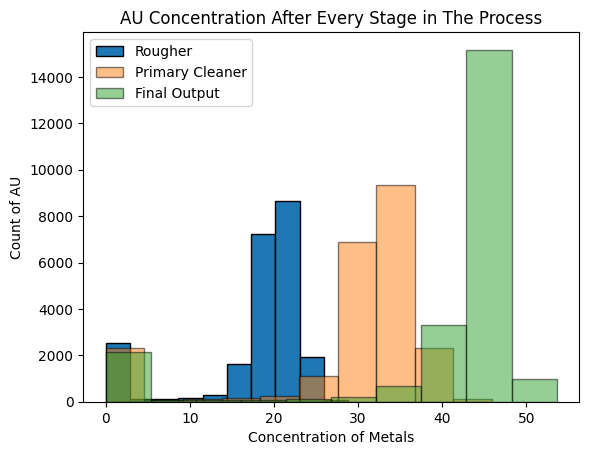

In [29]:
data_full["rougher.output.concentrate_au"].plot(
kind='hist', edgecolor='black', label = "Rougher")
data_full["primary_cleaner.output.concentrate_au"].plot(
kind='hist', alpha=.5, edgecolor='black', label = "Primary Cleaner")
data_full['final.output.concentrate_au'].plot(
kind='hist', alpha=.5, edgecolor='black', label = "Final Output")
plt.title("AU Concentration After Every Stage in The Process")
plt.ylabel("Count of AU")
plt.xlabel("Concentration of Metals")
plt.legend()
plt.show()

#### Analyzing AG

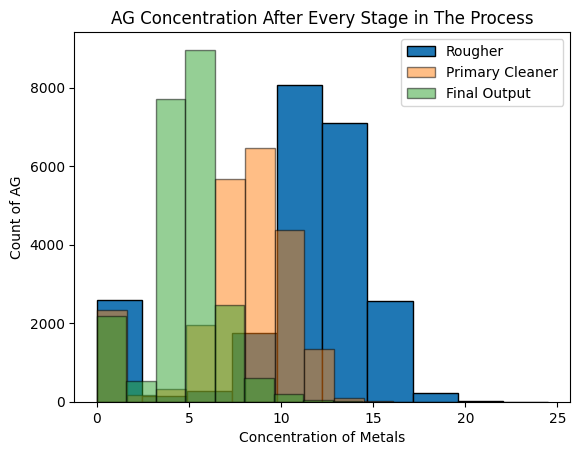

In [30]:
data_full["rougher.output.concentrate_ag"].plot(
kind='hist', edgecolor='black', label = "Rougher")
data_full["primary_cleaner.output.concentrate_ag"].plot(
kind='hist', alpha=.5, edgecolor='black', label = "Primary Cleaner")
data_full['final.output.concentrate_ag'].plot(
kind='hist', alpha=.5, edgecolor='black', label = "Final Output")
plt.title("AG Concentration After Every Stage in The Process")
plt.ylabel("Count of AG")
plt.xlabel("Concentration of Metals")
plt.legend()
plt.show()

#### Analyzing PB

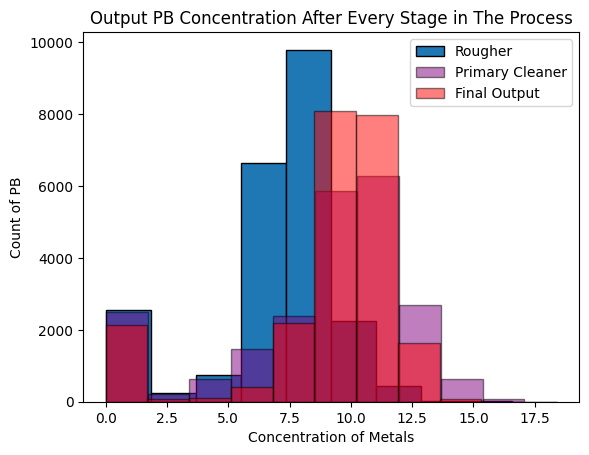

In [31]:
data_full["rougher.output.concentrate_pb"].plot(
kind='hist', edgecolor='black', label = "Rougher")
data_full["primary_cleaner.output.concentrate_pb"].plot(
kind='hist', alpha=.5, edgecolor='black', color='purple', label = "Primary Cleaner")
data_full['final.output.concentrate_pb'].plot(
kind='hist', alpha=.5, edgecolor='black', color='red', label = "Final Output")
plt.title("Output PB Concentration After Every Stage in The Process")
plt.ylabel("Count of PB")
plt.xlabel("Concentration of Metals")
plt.legend()
plt.show()

#### Comparing Concentration Mean Between Rougher Stage to Final Output

##### AU

In [32]:
mean_au_rougher = data_full['rougher.output.concentrate_au'].mean()
mean_au_final = data_full['final.output.concentrate_au'].mean()
au_mean_difference = mean_au_final - mean_au_rougher
print(f'''
The Mean of the Concentrate of AU in the rougher stage is:{mean_au_rougher:.2f}, 
and the mean of the AU in the final stage is {mean_au_final:.2f}, increasing by {au_mean_difference:.2f}
''')


The Mean of the Concentrate of AU in the rougher stage is:17.83, 
and the mean of the AU in the final stage is 39.89, increasing by 22.06



##### AG

In [33]:
mean_ag_rougher = data_full['rougher.output.concentrate_ag'].mean()
mean_ag_final = data_full['final.output.concentrate_ag'].mean()
ag_mean_difference = mean_ag_rougher - mean_ag_final
print(f'''
The Mean of the Concentrate of AG in the rougher stage is:{mean_ag_rougher:.2f}, 
and the mean of the AG in the final stage is {mean_ag_final:.2f}, decreasing by {ag_mean_difference:.2f}
''')


The Mean of the Concentrate of AG in the rougher stage is:10.85, 
and the mean of the AG in the final stage is 4.77, decreasing by 6.08



##### PB

In [34]:
mean_pb_rougher = data_full['rougher.output.concentrate_pb'].mean()
mean_pb_final = data_full['final.output.concentrate_pb'].mean()
pb_mean_difference = mean_pb_final - mean_pb_rougher
print(f'''
The Mean of the Concentrate of pb in the rougher stage is:{mean_pb_rougher:.2f}, 
and the mean of the pb in the final stage is {mean_pb_final:.2f}, increasing by {pb_mean_difference:.2f}
''')


The Mean of the Concentrate of pb in the rougher stage is:6.89, 
and the mean of the pb in the final stage is 9.07, increasing by 2.18



### Comparing Feed Particle Size Distributions Training and Test Set

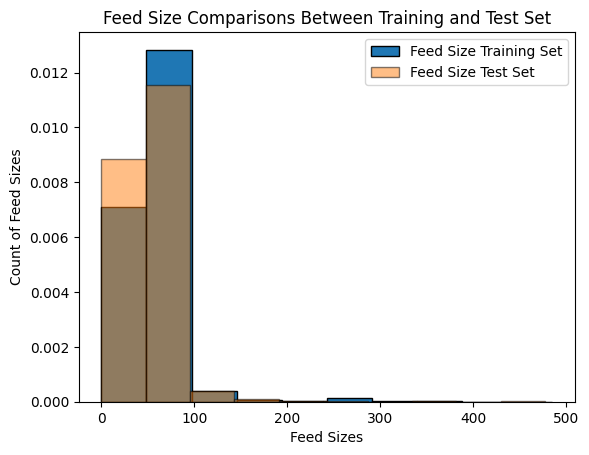

In [35]:
data_full['rougher.input.feed_size'].plot(
kind='hist', label='Feed Size Training Set', edgecolor='black', density = True)
data_test['rougher.input.feed_size'].plot(
kind='hist', label='Feed Size Test Set', alpha=.5, edgecolor='black', density=True)
plt.title('Feed Size Comparisons Between Training and Test Set')
plt.xlabel("Feed Sizes")
plt.ylabel("Count of Feed Sizes")
plt.legend()
plt.show()

As we compare the feed sizes for the training and the test set, you can see that both distributions are skewed to the right.

### Total Concentration of all Substances at Different Stages

#### Raw Feed

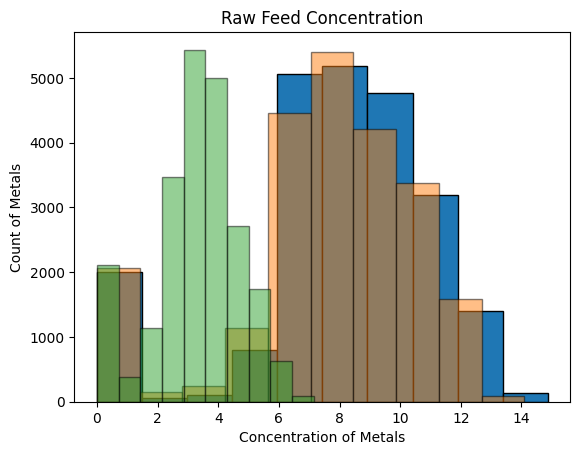

In [36]:
data_full['rougher.input.feed_ag'].plot(
kind='hist', edgecolor='black')
data_full['rougher.input.feed_au'].plot(
kind='hist', edgecolor='black', alpha=.5)
data_full['rougher.input.feed_pb'].plot(
kind='hist', edgecolor='black', alpha=.5)
plt.title("Raw Feed Concentration")
plt.ylabel("Count of Metals")
plt.xlabel("Concentration of Metals")
plt.show()

#### Rougher Concentrate

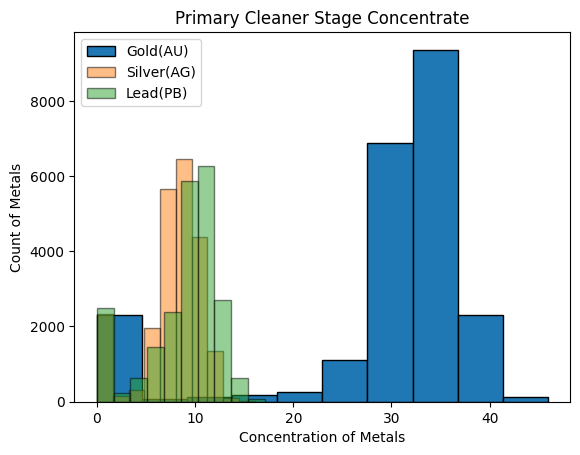

In [37]:
data_full["primary_cleaner.output.concentrate_au"].plot(
kind='hist', edgecolor='black', label="Gold(AU)")
data_full["primary_cleaner.output.concentrate_ag"].plot(
kind='hist', edgecolor='black', alpha=.5, label="Silver(AG)")
data_full["primary_cleaner.output.concentrate_pb"].plot(
kind='hist', edgecolor='black', alpha=.5, label="Lead(PB)")
plt.title("Primary Cleaner Stage Concentrate")
plt.ylabel("Count of Metals")
plt.xlabel("Concentration of Metals")
plt.legend()
plt.show()

#### Final Conentrate

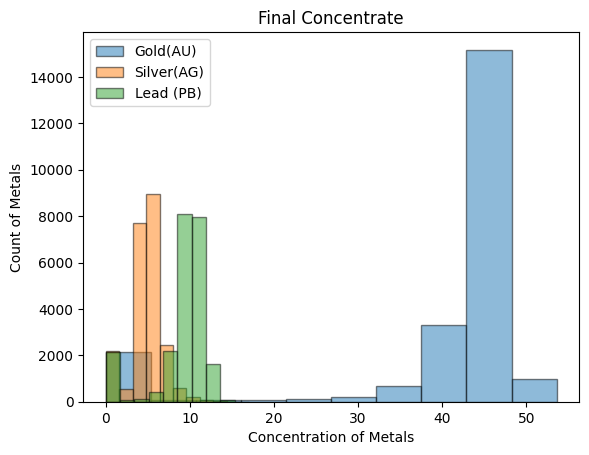

In [38]:
data_full['final.output.concentrate_au'].plot(
kind='hist', edgecolor='black', alpha=.5, label="Gold(AU)")
data_full['final.output.concentrate_ag'].plot(
kind='hist', edgecolor='black', alpha=.5, label="Silver(AG)")
data_full['final.output.concentrate_pb'].plot(
kind='hist', edgecolor='black', alpha=.5, label='Lead (PB)')
plt.legend()
plt.title("Final Concentrate")
plt.ylabel("Count of Metals")
plt.xlabel("Concentration of Metals")
plt.show()

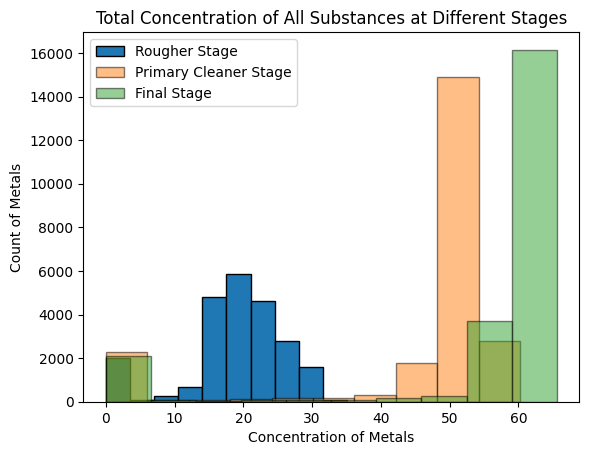

In [39]:
total_rougher = data_full["rougher.input.feed_au"] + data_full["rougher.input.feed_ag"] + data_full["rougher.input.feed_pb"]
total_primary = data_full['primary_cleaner.output.concentrate_au'] + data_full['primary_cleaner.output.concentrate_ag'] + data_full['primary_cleaner.output.concentrate_pb']
total_final = data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] + data_full['final.output.concentrate_pb']

total_rougher.plot(
kind='hist', label='Rougher Stage', edgecolor='black')
total_primary.plot(
kind='hist', alpha=.5, label="Primary Cleaner Stage", edgecolor='black')
total_final.plot(
kind='hist', alpha=.5, label="Final Stage", edgecolor='black')
plt.title("Total Concentration of All Substances at Different Stages")
plt.legend()
plt.ylabel("Count of Metals")
plt.xlabel("Concentration of Metals")
plt.show()


According to the total concentration histogram, you can see the distribution of the total concentration of all the medals on al the stages. As you can See, the concentration is lower on the beggining stages, and it increases when it gets to the primary cleaner stage and the final stage.

### Removing Outliers

#### Removing Outliers from the Training Set

In [40]:
Q1_train = data_train.quantile(.25)
Q3_train = data_train.quantile(.75)
IQR_train = Q3_train - Q1_train

lower_bound_train = Q1_train - 1.5 * IQR_train
upper_bound_train = Q3_train + 1.5 * IQR_train

data_train = data_train[(data_train >= lower_bound_train) & (data_train <= upper_bound_train)]

In [41]:
data_train = data_train.fillna(method='ffill')
data_train = data_train.dropna()

#### Cross-Validation

In [79]:
target_test

,rougher.output.recovery,final.output.recovery
349,79.513072,74.231478
350,80.861594,72.053490
351,84.672620,72.908173
352,84.804907,72.362224
353,83.157962,73.417916
...,...,...
7230,82.052011,64.639500
7231,80.306808,63.733126
7232,83.383725,66.048297
7233,83.916497,64.726474


In [82]:
filtered_data_train = data_train.drop(new_list,axis=1)
features_data_test = data_test.drop(['date'], axis=1)


features = filtered_data_train
target = data_train[['rougher.output.recovery', 'final.output.recovery']]
target_test = target_train[:5856]

rougher_recovery = []
for i in target_test['rougher.output.recovery']:
    rougher_recovery.append(i)

final_recovery = []
for i in target_test['final.output.recovery']:
    final_recovery.append(i)

In [53]:
def score_model(model, features, target, cv=4, weighted=False):
 
  scores = []
  kfold = KFold(n_splits=cv, shuffle=True, random_state=10) 

  for train_index, test_index in kfold.split(features):
    features_train, features_test = features.iloc[train_index], features.iloc[test_index]
    target_train, target_test = target.iloc[train_index], target.iloc[test_index]

    model.fit(features_train, target_train)
    predictions = model.predict(features_test)

    score = mean_absolute_error(target_test, predictions)
    scores.append(score)

  return scores


In [54]:
model_decision_tree = DecisionTreeRegressor()
model_random_forest = RandomForestRegressor()
model_linear = LinearRegression()

In [55]:
scores_linear = score_model(model_linear, features, target, cv=4)
scores_random_forest = score_model(model_random_forest, features, target, cv=4)
scores_decision_tree = score_model(model_decision_tree, features, target, cv=4)


print("Evaluation scores for each fold in Linear Regression:", scores_linear)
print("Average score:", np.mean(scores_linear))
print()
print("Evaluation scores for each fold in Random Forest:", scores_random_forest)
print("Average score:", np.mean(scores_random_forest))
print()
print("Evaluation scores for each fold in Decision Tree:", scores_decision_tree)
print("Average score:", np.mean(scores_decision_tree))

Evaluation scores for each fold in Linear Regression: [3.8588494748207665, 3.855973630704795, 3.9094198893536367, 3.9847056690983624]
Average score: 3.90223716599439

Evaluation scores for each fold in Random Forest: [2.3445708845628204, 2.4073362744584883, 2.4365603679101846, 2.4732273948299297]
Average score: 2.415423730440356

Evaluation scores for each fold in Decision Tree: [3.3142268620097943, 3.2926699223208002, 3.3759387353982184, 3.456870777725443]
Average score: 3.359926574363564


### SMAPE (Symmetric Mean Absolute Percentage Error) Metric

In [111]:
def smape(y_true, y_pred):
    error = (y_true - y_pred).abs()
    scale = (y_true.abs() + y_pred) / 2
    
    return (error / scale).mean()

def final_smape(rougher, final):
    
    return 0.25 * rougher + .75 * final

In [63]:
model_random_forest = RandomForestRegressor(n_estimators=5, max_features=None)
model_random_forest.fit(features, target_train)
prediction = model_random_forest.predict(features_data_test)

In [112]:
SMAPE = smape(target_test, prediction)
SMAPE

rougher.output.recovery    0.089936
final.output.recovery      0.116317
dtype: float64

In [118]:
final_SMAPE = final_smape(SMAPE[0], SMAPE[1])
print(f"Final Smape: {final_SMAPE:.2f}")

Final Smape: 0.11


### Conclusion

After determining that the best machine learning model for this data set is a Random Forest Regressor, I caluclated the SMAPE (Symmetric Mean Absolute Percentage Error) metric between target and prediction of "rougher.output.recovery" and "final.output.recovery", I was able to calculate a symmetic mean absolute percentage error of 0.11. using Random Forest Regressor and using cross validation.